In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Data Cleaning

We start by investigating the data, doing some standard plots and the like.

In [75]:
trainset = pd.read_csv("train.csv")

In [76]:
trainset.shape
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Here we create a new dummy variable correspodning to Sex with 
    Male = 1 and Female = 0.
      
We also note that some of the observations having missing values for age. This might contain information in the sense that people with a missing age may be more or less likely to survive.

Missing cabin may also influence the probability of survival so we should account for this. For plotting purposes we should also make age into a categorical variable.

There seems to be some interesting information in the alphabetic part of ticket name so we create a column of the first letters.

Also there is some missing values for age that we should clean. 

In [77]:
def recodesex(sex):
    if sex=="male":
        return 1
    elif sex=="female":
        return 0
    else:
        return None

def recodeage(age):
    if age < 18:
        return "Kid"
    elif age > 18 and age < 40:
        return "Middle age"
    elif age > 40:
        return "Old"
    else:
        return "Missing"

def recodeticket(tick):
    k = 0
    i = 0
    out = ""
    while k < 2:
        if i == len(tick)-1:
            k=2
        
        if i==0 and tick[i] in list(["0","1", "2", "3", "4", "5", "6","7", "8", "9", "10"]):
            out="Missing"
            k = 2
        elif i!=0 and tick[i] in list(["0","1", "2", "3", "4", "5", "6","7", "8", "9", "10"]):
            out = out + tick[i]
            i = i+1
            k = k+1
        elif i!=0 and tick[i]==" ":
            k = 2
        elif tick[i] not in list(["0","1", "2", "3", "4", "5", "6","7", "8", "9", "10"]):
            out = out + tick[i]
            i = i+1
    
    out=out.replace('.', '')
    out=out.replace('/', '')
    out=out.upper()    
    return out


def missingage(alder, mu):
    if pd.isna(alder):
        val = mu
        return val
    else:
        return alder


In [78]:
NullAge = trainset.loc[trainset['Age'].isnull(), ['PassengerId', 'Age']]
NotNullAge = trainset.loc[trainset['Age'].notnull(), ['PassengerId', 'Age']]
NullAge['MissingAge'] = [1] * NullAge.shape[0]
NotNullAge['MissingAge'] = [0] * NotNullAge.shape[0] 
MissingAgeCol = pd.concat([NullAge, NotNullAge], axis=0).loc[:,['PassengerId', 'MissingAge']]

NullCabin = trainset.loc[trainset['Cabin'].isnull(), ['PassengerId', 'Cabin']]
NotNullCabin = trainset.loc[trainset['Cabin'].notnull(), ['PassengerId', 'Cabin']]
NullCabin['MissingCabin']=[1] * NullCabin.shape[0]
NotNullCabin['MissingCabin']=[0] * NotNullCabin.shape[0]
MissingCabinCol = pd.concat([NullCabin, NotNullCabin], axis=0).loc[:,['PassengerId', 'MissingCabin']]




In [79]:
trainset['sexC']=trainset['Sex'].apply(recodesex)
trainset['catage']=trainset['Age'].apply(recodeage)
trainset['TicketPrefix']=trainset['Ticket'].apply(recodeticket)
avg = trainset['Age'].mean(skipna=True)
trainset['Age']=trainset['Age'].apply(missingage, mu=avg)

TicketFreqs=pd.DataFrame(trainset['Ticket'].value_counts())
TicketFreqs.reset_index(level=0, inplace=True)
TicketFreqs.rename(columns={'index':'Ticket', 'Ticket':'TicketCount'}, inplace=True)

if 'TicketCount' not in list(trainset.columns):
    trainset=trainset.merge(TicketFreqs, left_on='Ticket', right_on='Ticket')
if 'MissingAge' not in list(trainset.columns):
    trainset=trainset.merge(MissingAgeCol, left_on='PassengerId', right_on='PassengerId')
if 'MissingCabin' not in list(trainset.columns):
    trainset=trainset.merge(MissingCabinCol, left_on ='PassengerId', right_on='PassengerId')



In [80]:
TicketPrefixCount = pd.DataFrame(trainset['MissingCabin'].value_counts())
print(TicketPrefixCount)


   MissingCabin
1           687
0           204


# Visualizing the data

Now that we have fixed the datat in the trainset dataset we are ready to visualize the data a bit. We start by investigating the scatterplot matrix in order to investigate if there is some correlation between certain variables. This may be used later when we do some feature engineering and tweaking.

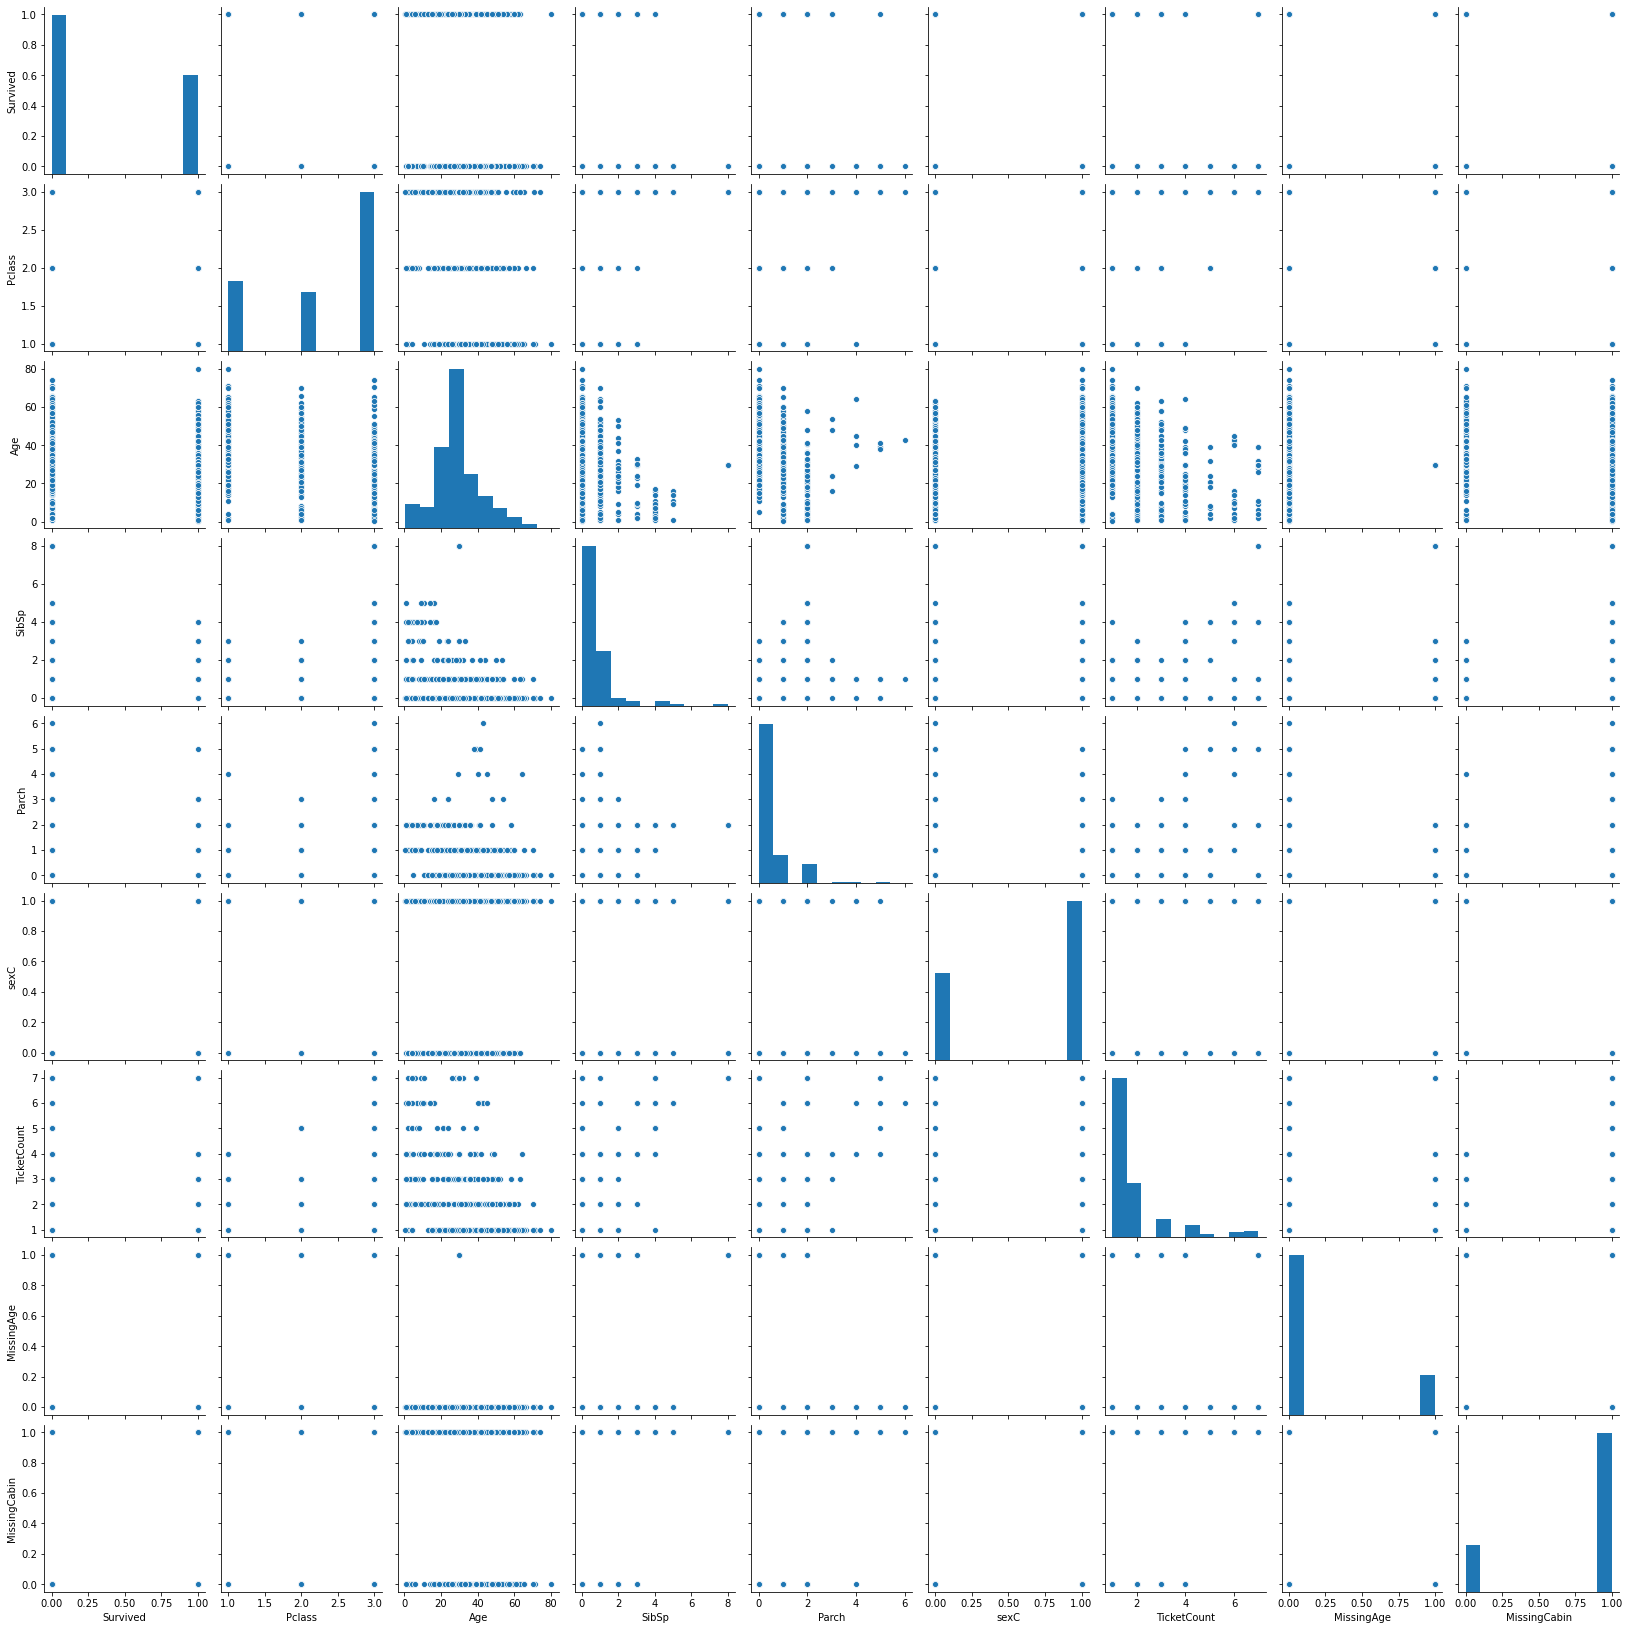

In [9]:
sns.pairplot(trainset.drop(["Sex", "Name", "PassengerId", "Ticket", "Fare", "Name", "TicketPrefix"], axis=1))
plt.show()

It might be more reasonable to look at bar charts with splitted bars to see how the different levels affect the porportion that survived.

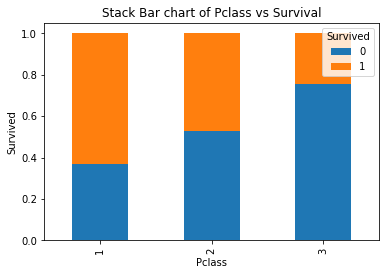

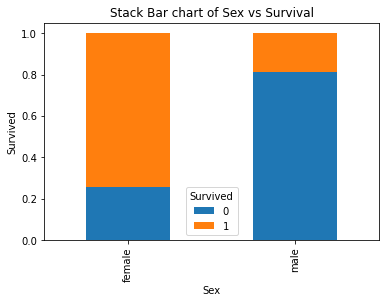

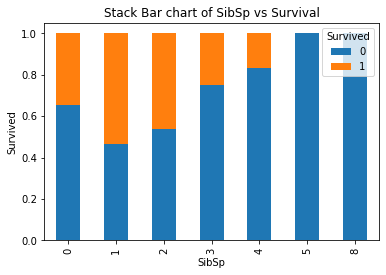

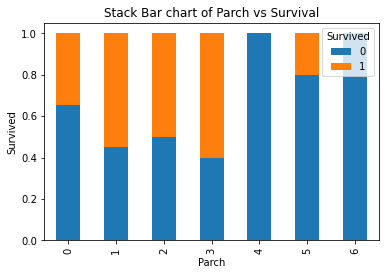

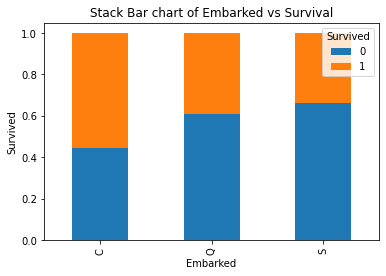

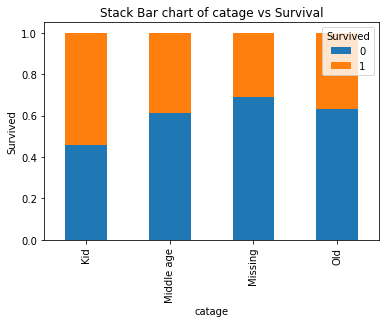

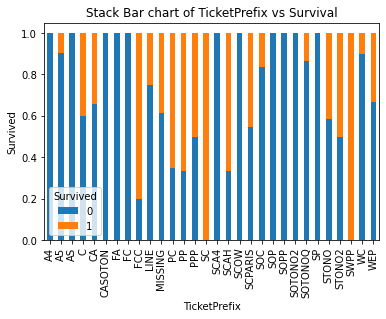

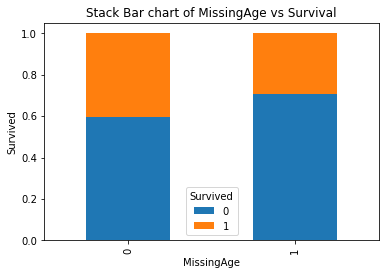

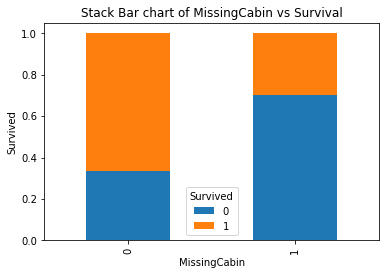

In [10]:
vars=['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'catage', 'TicketPrefix', 'MissingAge', 'MissingCabin']

for i in enumerate(vars):
    table=pd.crosstab(trainset[i[1]], trainset['Survived'])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title('Stack Bar chart of ' + i[1] + ' vs Survival')
    plt.xlabel(i[1])
    plt.ylabel('Survived')

plt.show()
    

From the plots above we can see that considerably more females than males survived so this variable is probably a very strong predictor of whether or not a person survives. Also, class seems to have a strong effect since more people from first class survived than from third class.


In [81]:
print(trainset.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'sexC', 'catage',
       'TicketPrefix', 'TicketCount', 'MissingAge', 'MissingCabin'],
      dtype='object')


Next we create dummy variables for the categorical variables in order to easily create the design matrix later. We also remove the variables that we will not be used. 

In [89]:
if 'catage' in list(trainset.columns):
    dropvars = ['sexC', 'catage', 'Name', 'Ticket', 'PassengerId']
    trainset.drop(dropvars, axis=1, inplace=True)

# Create a list with the categorical variables

print(trainset.dtypes)


Survived          int64
Pclass            int64
Sex              object
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Cabin            object
Embarked         object
TicketPrefix     object
TicketCount       int64
MissingAge        int64
MissingCabin      int64
dtype: object


In [13]:
trainset.shape


(891, 191)


# Random Forest Model

In this section we try to fit the random forest model to the data. We will be using scikitlearn for the random forest model and this requires us to put the input (or features) into a numpy array as below. 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [15]:
labels = np.array(trainset['Survived'])
trainset_rf = trainset.drop('Survived', axis = 1)
feature_list = list(trainset_rf.columns)
features = np.array(trainset_rf)

print (trainset_rf.columns)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TicketCount', 'MissingAge',
       'MissingCabin', 'Sex_female', 'Sex_male',
       ...
       'TicketPrefix_SOP', 'TicketPrefix_SOPP', 'TicketPrefix_SOTONO2',
       'TicketPrefix_SOTONOQ', 'TicketPrefix_SP', 'TicketPrefix_STONO',
       'TicketPrefix_STONO2', 'TicketPrefix_SWPP', 'TicketPrefix_WC',
       'TicketPrefix_WEP'],
      dtype='object', length=190)


Next we create a train set and a testing set nad check so that the dimensions of the matrices/vectors match.

In [16]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.1, random_state=42)
print("Training features dimension:" , train_features.shape)
print("Training labels dimension:", train_labels.shape)
print("Testing features dimension:", test_features.shape)
print("Test labels dimension:", test_labels.shape)


Training features dimension: (801, 190)
Training labels dimension: (801,)
Testing features dimension: (90, 190)
Test labels dimension: (90,)


Next, we start to fit a very simple random forest model to the data. This is a very simple process. We also make predictions on the training set first and see how it does.

In [22]:
model = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features=None)
model.fit(train_features, train_labels)

RandomForestClassifier(max_features=None)

In [23]:
prob_hat_train = model.predict_proba(train_features)
y_hat_train = model.predict(train_features)
print("Accurarcy of the model on training set: ", metrics.accuracy_score(train_labels, y_hat_train))

Accurarcy of the model on training set:  0.9937578027465668


Now we check the accuracy on the validation data set that we created. 

In [25]:
y_hat_test=model.predict(test_features)
print ("Accuracy of the model on the validation set: ", metrics.accuracy_score(test_labels, y_hat_test))

Accuracy of the model on the validation set:  0.8111111111111111


So, we get about 80% accuracy on the validation set. Ideally we should tune the random forest parameters using cross fold validation.
We start by optimizing for the number of variables to be included in the classification trees. It looks like the optimum is to choose max_features = "auto".

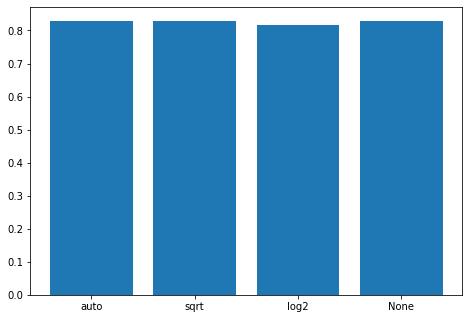

[0.8277096273291924, 0.8302018633540372, 0.8164596273291925, 0.8276785714285714]


In [26]:
nfeatures = ["auto", "sqrt", "log2", None]
cv_means = []
nfeatures_plot = ["auto", "sqrt", "log2", "None"]

for i in nfeatures:
    model = RandomForestClassifier(n_estimators=1000, bootstrap=True, max_features=i, oob_score=True)
    cv_scores = cross_val_score(model, train_features, train_labels, cv=5)
    cv_means.append(np.mean(cv_scores))
    

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(nfeatures_plot, cv_means)
plt.show()
print(cv_means)


It looks like (based on the above) that max_features = "auto" is the approriate choice. Next we look at the effect of the number of trees (the more the merrier probably). We will test for different numbers of max_features.

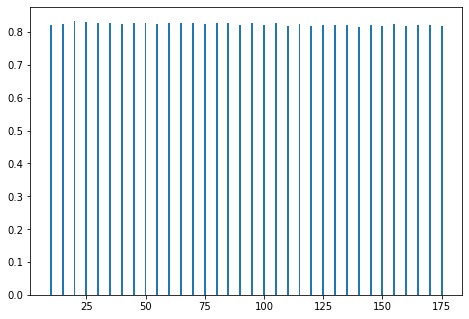

[0.8227018633540373, 0.8252096273291926, 0.8351863354037267, 0.831444099378882, 0.8289440993788819, 0.8289440993788819, 0.825194099378882, 0.8264518633540373, 0.8289285714285715, 0.8239596273291927, 0.8264518633540373, 0.8277018633540372, 0.8276940993788819, 0.823944099378882, 0.8276940993788819, 0.8264518633540373, 0.8227018633540373, 0.8276708074534161, 0.8226863354037267, 0.8264363354037266, 0.8189518633540374, 0.8239363354037268, 0.8189440993788819, 0.8202018633540373, 0.8201863354037267, 0.8214518633540372, 0.8152018633540372, 0.8201940993788821, 0.8189596273291926, 0.8239363354037268, 0.8189518633540371, 0.8202018633540373, 0.8226863354037267, 0.8189440993788819]


In [105]:
nfeatures = list(range(10, 180, 5))
cv_means = []
nfeatures_plot = list(range(10, 180, 5))

for i in nfeatures:
    model = RandomForestClassifier(n_estimators=1000, bootstrap=True, max_features=i, oob_score=True)
    cv_scores = cross_val_score(model, train_features, train_labels, cv=5)
    cv_means.append(np.mean(cv_scores))
    

 

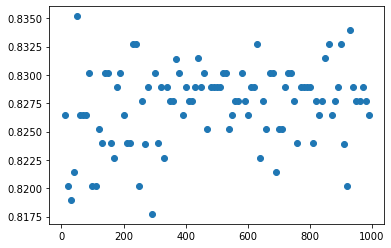

In [81]:
cv_means = []

for i in range(10, 1000, 10):
    if i==0:
        i = 1
    model = RandomForestClassifier(n_estimators=i, bootstrap=True, max_features = "auto")
    cv_scores = cross_val_score(model, train_features, train_labels, cv=5)
    cv_means.append(np.mean(cv_scores))
    

plt.plot(list(range(10, 1000, 10)), cv_means, 'o')



So, it looks like the accuracy increases is not necessaryily a function of the number of tree (so long as you do not choose too few). So lets choose about 400 trees.

In [27]:
model_final_rf = RandomForestClassifier(n_estimators=400, bootstrap=True, max_features=150, oob_score=True)
model_final_rf.fit(train_features, train_labels)

RandomForestClassifier(max_features=150, n_estimators=400, oob_score=True)

In [28]:
prob_hat_train = model_final_rf.predict_proba(train_features)
y_hat_train = model_final_rf.predict(train_features)
print("Accurarcy of the model on training set: ", metrics.accuracy_score(train_labels, y_hat_train))

Accurarcy of the model on training set:  0.9937578027465668


In [29]:
y_hat_test=model_final_rf.predict(test_features)
print ("Accuracy of the model on the validation set: ", metrics.accuracy_score(test_labels, y_hat_test))

Accuracy of the model on the validation set:  0.8333333333333334


This seems to be the most we can get out of the random forest classifier. 

# Gradient Boosting Trees

In this section we will attempt to fit a gradient boosting tree to the data. The idea is to fit a model consisting of a linear combination of classifier trees where the parameters of the trees and is determined by fitting regression tree to pseudo-residuals (see Elements of Statistical Learning). We start by fitting a very crude model, then we can tune the parameters.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
model_GTB = GradientBoostingClassifier(n_estimators = 10000, learning_rate=0.05, random_state=0, max_depth=2).fit(train_features, train_labels)
prob_hat_train = model_GTB.predict_proba(train_features)
y_hat_train = model_GTB.predict(train_features)
print("Accurarcy of the model on training set: ", metrics.accuracy_score(train_labels, y_hat_train))

Accurarcy of the model on training set:  0.982521847690387


Now we also test the model predictions on the test data.

In [21]:
y_hat_test=model_GTB.predict(test_features)
print ("Accuracy of the model on the validation set: ", metrics.accuracy_score(test_labels, y_hat_test))

Accuracy of the model on the validation set:  0.8333333333333334


It seems like there are some things that can be tuned, mainly we look at the max_depth of the tree (the maximum number of nodes in each tree), shrinkage and the number of boosted trees. So, we will now attempt to tune these parameters using cross fold validation on the training set. We start by investigating the depth of each tree.

Text(0, 0.5, 'Accuracy')

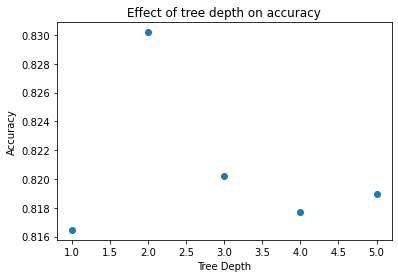

In [43]:
cv_means = []
for i in range(1,6):
    modeliter_GTB = GradientBoostingClassifier(n_estimators = 200, learning_rate=0.05, random_state=0, max_depth=i)
    cv_scores = cross_val_score(modeliter_GTB, train_features, train_labels, cv=5)
    cv_means.append(np.mean(cv_scores))
    
plt.plot(list(range(1,6)), cv_means, "o")
plt.title("Effect of tree depth on accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")

So it definitely looks like we should use a tree depth = 2, which is nice because thats what people usually recommend.

Next we investigate the effect of the number of tree included in the boosting.


Text(0, 0.5, 'Accuracy')

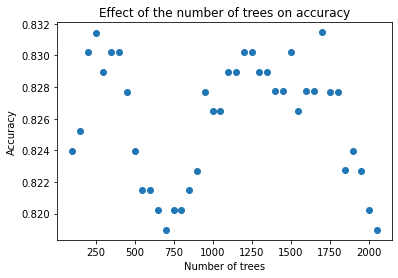

In [35]:
cv_means = []
for i in range(100,2100, 50):
    modeliter_GTB = GradientBoostingClassifier(n_estimators = i, learning_rate=0.05, random_state=0, max_depth=2).fit(train_features, train_labels)
    cv_scores = cross_val_score(modeliter_GTB, train_features, train_labels, cv=5)
    cv_means.append(np.mean(cv_scores))


plt.plot(list(range(100,2100,50)), cv_means, "o")
plt.title("Effect of the number of trees on accuracy")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

So, it looks like aroudn 1250 trees seem to be optimal. Now we investigate the effect of shrinkage (learning rate). This is probably dependent on the number of trees, but oh well.

Text(0, 0.5, 'Accuracy')

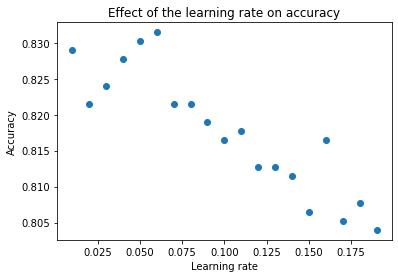

In [42]:
cv_means = []
quotients = []
for i in range(1,20, 1):
    modeliter_GTB = GradientBoostingClassifier(n_estimators = 1250, learning_rate=i/100, random_state=0, max_depth=2).fit(train_features, train_labels)
    cv_scores = cross_val_score(modeliter_GTB, train_features, train_labels, cv=5)
    cv_means.append(np.mean(cv_scores))
    quotients.append(i/100)

plt.plot(quotients, cv_means, "o")
plt.title("Effect of the learning rate on accuracy")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")

So, it looks like a learning rate of 0.05 is appropriate when we have the number of trees equal to 1250. So now we create a final model that corresponds to gradient boosting trees, and look how it performs on the self-defined test set.

In [57]:
model_final_GTB = GradientBoostingClassifier(n_estimators = 1250, learning_rate=0.05, random_state=1, max_depth=2).fit(train_features, train_labels)
y_hat_train = model_final_GTB.predict(train_features)
print("Accurarcy of the model on training set: ", metrics.accuracy_score(train_labels, y_hat_train))

Accurarcy of the model on training set:  0.9088639200998752


In [ ]:
y_hat_test=model_final_GTB.predict(test_features)
print ("Accuracy of the model on the validation set: ", metrics.accuracy_score(test_labels, y_hat_test))

# Prepare the test data using the same operations

In [25]:
testset = pd.read_csv("test.csv")

In [ ]:
NullAge = testset.loc[testset['Age'].isnull(), ['PassengerId', 'Age']]
NotNullAge = testset.loc[testset['Age'].notnull(), ['PassengerId', 'Age']]
NullAge['MissingAge'] = [1] * NullAge.shape[0]
NotNullAge['MissingAge'] = [0] * NotNullAge.shape[0] 
MissingAgeCol = pd.concat([NullAge, NotNullAge], axis=0).loc[:,['PassengerId', 'MissingAge']]

In [46]:
NullCabin = testset.loc[testset['Cabin'].isnull(), ['PassengerId', 'Cabin']]
NotNullCabin = testset.loc[testset['Cabin'].notnull(), ['PassengerId', 'Cabin']]
NullCabin['MissingCabin']=[1] * NullCabin.shape[0]
NotNullCabin['MissingCabin']=[0] * NotNullCabin.shape[0]
MissingCabinCol = pd.concat([NullCabin, NotNullCabin], axis=0).loc[:,['PassengerId', 'MissingCabin']]


In [53]:
testset['sexC']=testset['Sex'].apply(recodesex)
testset['catage']=testset['Age'].apply(recodeage)
testset['TicketPrefix']=testset['Ticket'].apply(recodeticket)
avg = trainset['Age'].mean(skipna=True)
testset['Age']=testset['Age'].apply(missingage, mu=avg)

TicketFreqs=pd.DataFrame(testset['Ticket'].value_counts())
TicketFreqs.reset_index(level=0, inplace=True)
TicketFreqs.rename(columns={'index':'Ticket', 'Ticket':'TicketCount'}, inplace=True)

if 'TicketCount' not in list(testset.columns):
    testset=testset.merge(TicketFreqs, left_on='Ticket', right_on='Ticket')
if 'MissingAge' not in list(testset.columns):
    testset=testset.merge(MissingAgeCol, left_on='PassengerId', right_on='PassengerId')
if 'MissingCabin' not in list(testset.columns):
    testset=testset.merge(MissingCabinCol, left_on ='PassengerId', right_on='PassengerId')



In [64]:
testset_rf = testset

#if 'catage' in list(features_test.columns):
#    dropvars = ['sexC', 'catage', 'Name', 'Ticket', 'PassengerId']
#    features_test.drop(dropvars, axis=1, inplace=True)

print(testset_rf.columns)    
    
features_test=pd.get_dummies(features_test)
feature_list = list(testset_rf.columns)
features_test = np.array(testset_rf)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'sexC', 'catage', 'TicketPrefix',
       'TicketCount', 'MissingAge', 'MissingCabin'],
      dtype='object')


Exception: Data must be 1-dimensional

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# Submission random forest

Since the random forest performed the best on the test set we will submit that model. But first, we fit the model to the entire dataset to get the best model possible. The numpy array called features contains the features and

In [22]:
model_final_rf_submit = RandomForestClassifier(n_estimators=400, bootstrap=True, max_features=150, oob_score=True)
model_final_rf_submit.fit(features, labels)

RandomForestClassifier(max_features=150, n_estimators=400, oob_score=True)

In [62]:
y_hat_submit = model_final_rf_submit.predict(features_test)


ValueError: could not convert string to float: 'Kelly, Mr. James'